# Logistic ANOVAs and Regressions

*I'm reorganizing things a bit to make it easier to read everything*

## Load data

In [2]:
import pandas as pd
# I moved some of the data load down here so it is easier to read with your function call
df_combined = pd.read_csv("/srv/2025-city_leadership/combined_data_clean.csv")
df_senior = pd.read_csv("/srv/2025-city_leadership/combined_data_clean.csv")
df_followup = pd.read_csv("/srv/2025-city_leadership/combined_data_clean.csv")

In [3]:
# df_combined.columns

## Analysis functions

### Logistic Regression

In [4]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import statsmodels.stats.multicomp as mc

def run_logistic_regression(df, outcome, predictor):
    temp = df[[outcome, predictor]].dropna()

    # We want the predictor to be numeric, so you don't need the C() syntax
    model = smf.glm(f'{outcome} ~ {predictor}', data=temp, family=sm.families.Binomial()).fit()

    # For plotting I'm not sure what the best way is. Here are two ways
    fig = plt.figure()
    plt.title(f'Logistic regression of {outcome} on {predictor} (data shown)')
    plt.scatter(temp[predictor],temp[outcome])
    plt.scatter(temp[predictor],model.predict(),c='red')
    plt.ylabel(f'{outcome}')
    plt.xlabel(f'{predictor}')
    plt.show
    
    fig2 = plt.figure()
    plt.title(f'Logistic regression of {outcome} on {predictor} (data not shown)')
    plt.scatter(temp[predictor],model.predict(),c='red')
    plt.ylabel(f'{outcome}')
    plt.xlabel(f'{predictor}')
    plt.show

    return model.summary()

### Logistic ANOVA with posthocs

In [5]:
def run_glm_nested_comparison(df, outcome, categorical_var):
    temp = df[[outcome, categorical_var]].dropna()
    full_model = smf.glm(f'{outcome} ~ C({categorical_var})', data=temp, family=sm.families.Binomial()).fit()
    null_model = smf.glm(f'{outcome} ~ 1', data=temp, family=sm.families.Binomial()).fit()

    def calculate_nested_f_statistic(small_model, big_model):
        addtl_params = big_model.df_model - small_model.df_model
        f_stat = (small_model.deviance - big_model.deviance) / (addtl_params * big_model.scale)
        df_numerator = addtl_params
        df_denom = (big_model.fittedvalues.shape[0] - big_model.df_model)
        p_value = stats.f.sf(f_stat, df_numerator, df_denom)
        return f_stat, p_value

    f_stat, p_value = calculate_nested_f_statistic(null_model, full_model)
    print(f"Nested Model Comparison:\nF-statistic = {f_stat:.4f}, p-value = {p_value:.8f}")

    means_table = temp.groupby(categorical_var)[outcome].mean().reset_index()
    print("\nGroup Means Table:")
    print(means_table)

    # suggest moving this out so plots can be made always
    posthocs = pairwise_tukeyhsd(endog=temp[outcome], groups=temp[categorical_var])
    
    if temp[categorical_var].nunique() > 2:
        print("\nTukey HSD Results:")
        print(posthocs)
    else:
        print("\nTukey HSD skipped (only 2 groups present).")

    # suggest moving this out so that plot is made even if only 2 groups present
    posthocs.plot_simultaneous()
    plt.title(f'Tukey HSD: {outcome} by {categorical_var}')
    plt.xlabel("Mean Difference")
    plt.grid(True)
    plt.show()

    # may not need to return anything b/c it is all printed
    # return f_stat, p_value, means_table

# fus_actual_equals_intended

## Analyses: Logistic Regression

- ACT: `ss_act_score`
- GPA: `ss_unweighted_gpa`

### ACT

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Generalized Linear Model Regression Results                      
======================================================================================
Dep. Variable:     fus_actual_equals_intended   No. Observations:                  613
Model:                                    GLM   Df Residuals:                      611
Model Family:                        Binomial   Df Model:                            1
Link Function:                          Logit   Scale:                          1.0000
Method:                                  IRLS   Log-Likelihood:                -340.74
Date:                        Wed, 02 Jul 2025   Deviance:                       681.48
Time:                                16:56:22   Pearson chi2:                     620.
No. Iterations:                             4   Pseudo R-squ. (CS):            0.05786
Covariance Type:                    nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.5508      0.448     -3.462      0.001      -2.429      -0.673
ss_act_score     0.1291      0.023      5.608      0.000       0.084       0.174
================================================================================
"""

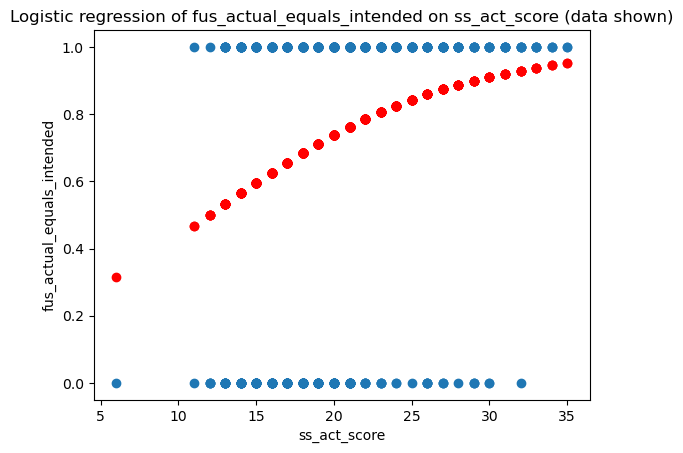

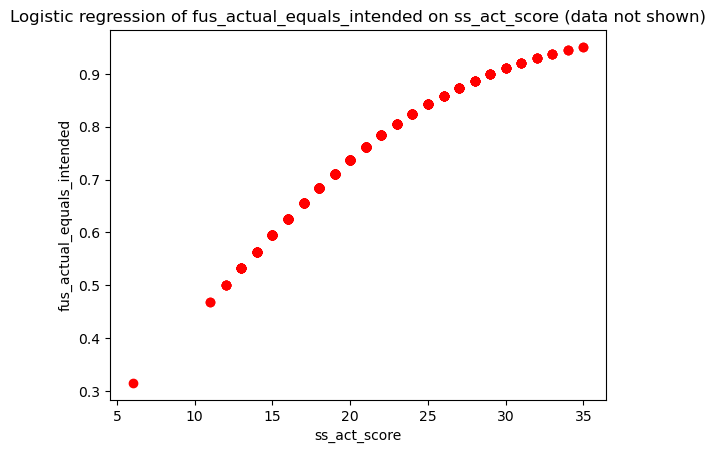

In [6]:
temp = df_combined

# Filter crazy values before fitting the model, ACT is 1 to 36 but I doubt the "2" scores are real
temp = temp[temp['ss_act_score'] > 2]
temp = temp[temp['ss_act_score'] <= 36]

run_logistic_regression(temp, outcome='fus_actual_equals_intended', predictor='ss_act_score')

### GPA

In [9]:
# I checked and unweighted should be 1 to 4; it can only be higher than 4 if weighted
df_combined['ss_unweighted_gpa'].describe()

count    367.000000
mean       3.516158
std        0.574543
min        1.790000
25%        3.125000
50%        3.600000
75%        3.900000
max        5.800000
Name: ss_unweighted_gpa, dtype: float64

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Generalized Linear Model Regression Results                      
======================================================================================
Dep. Variable:     fus_actual_equals_intended   No. Observations:                  330
Model:                                    GLM   Df Residuals:                      328
Model Family:                        Binomial   Df Model:                            1
Link Function:                          Logit   Scale:                          1.0000
Method:                                  IRLS   Log-Likelihood:                -165.58
Date:                        Wed, 02 Jul 2025   Deviance:                       331.16
Time:                                16:58:33   Pearson chi2:                     324.
No. Iterations:                             4   Pseudo R-squ. (CS):            0.08623
Covariance Type:                    nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -3.2687      0.833     -3.922      0.000      -4.902      -1.635
ss_unweighted_gpa     1.3308      0.251      5.293      0.000       0.838       1.824
=====================================================================================
"""

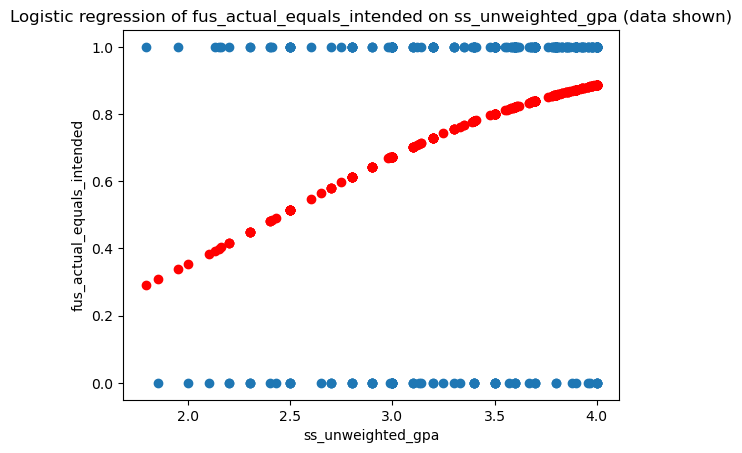

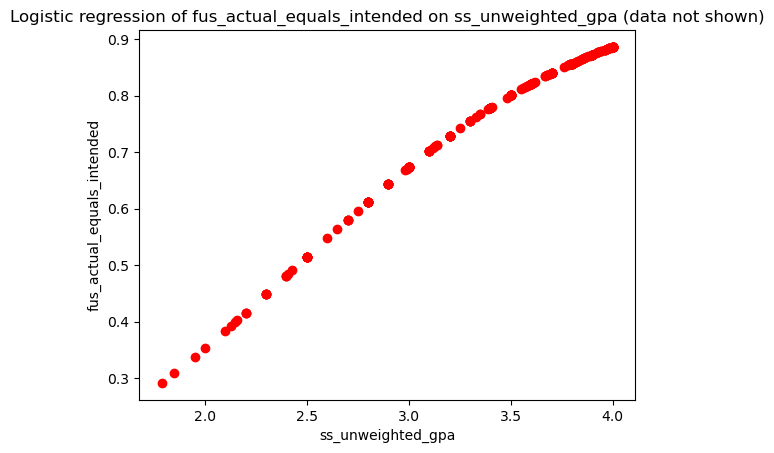

In [10]:
temp = df_combined

temp = temp[temp['ss_unweighted_gpa'] <= 4]

run_logistic_regression(temp, outcome='fus_actual_equals_intended', predictor='ss_unweighted_gpa')

## Analyses: Logistic ANOVA

- Race/ethnicity: `fus_race_ethnicity`
- High school: `fus_high_school`
- Gender: `fus_gender`
- **Intention after high school** is a new one you added, looks cool
- Graduation year: `ss_student_high_school_graduation_year`

### Race

Nested Model Comparison:
F-statistic = 2.0704, p-value = 0.04433201

Group Means Table:
                 fus_race_ethnicity  fus_actual_equals_intended
0                             Asian                    0.666667
1            Black/African American                    0.630197
2              Choose Not to Answer                    0.434783
3  Hispanic or Latino/Latina/LatinX                    0.600000
4      Middle Eastern/North African                    1.000000
5                      Multi-Racial                    0.687500
6                             Other                    0.666667
7                             White                    0.752475

Tukey HSD Results:
                          Multiple Comparison of Means - Tukey HSD, FWER=0.05                          
             group1                           group2              meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------------------------------------------
    

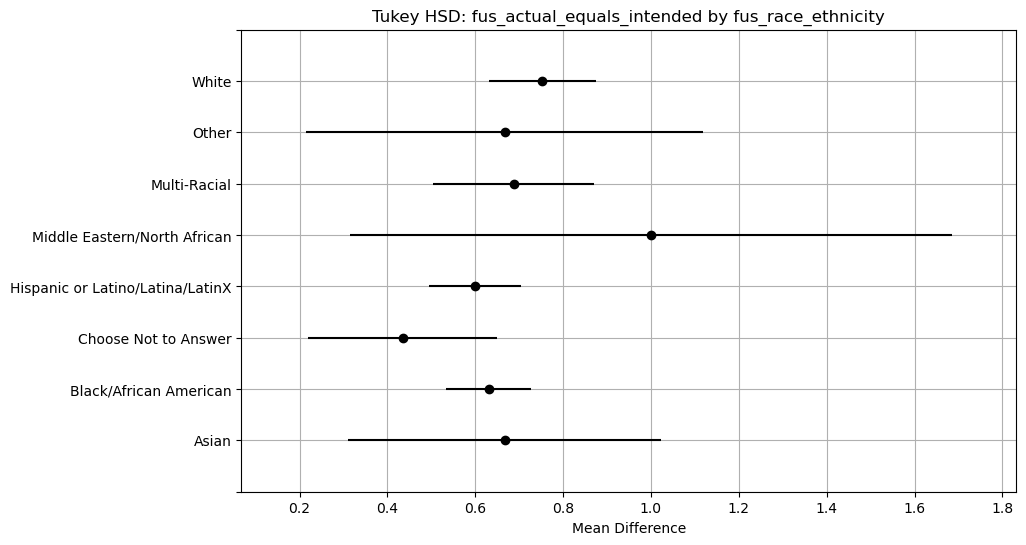

In [11]:
run_glm_nested_comparison(df_combined, outcome='fus_actual_equals_intended', categorical_var='fus_race_ethnicity')

### High school

Nested Model Comparison:
F-statistic = 5.8073, p-value = 0.00000000

Group Means Table:
                             fus_high_school  fus_actual_equals_intended
0               Collegiate School of Memphis                    0.867769
1       Compass School - Midtown High School                    0.507853
2                      Crosstown High School                    0.651757
3                            Harding Academy                    1.000000
4                 Lausanne Collegiate School                    1.000000
5   Memphis Academy of Science & Engineering                    0.000000
6                 New Hope Christian Academy                    0.900000
7                                      Other                    1.000000
8                  Soulsville Charter School                    0.602679
9                 St. Benedict at Auburndale                    0.000000
10               St. Mary's Episcopal School                    1.000000
11                 White Station Hig

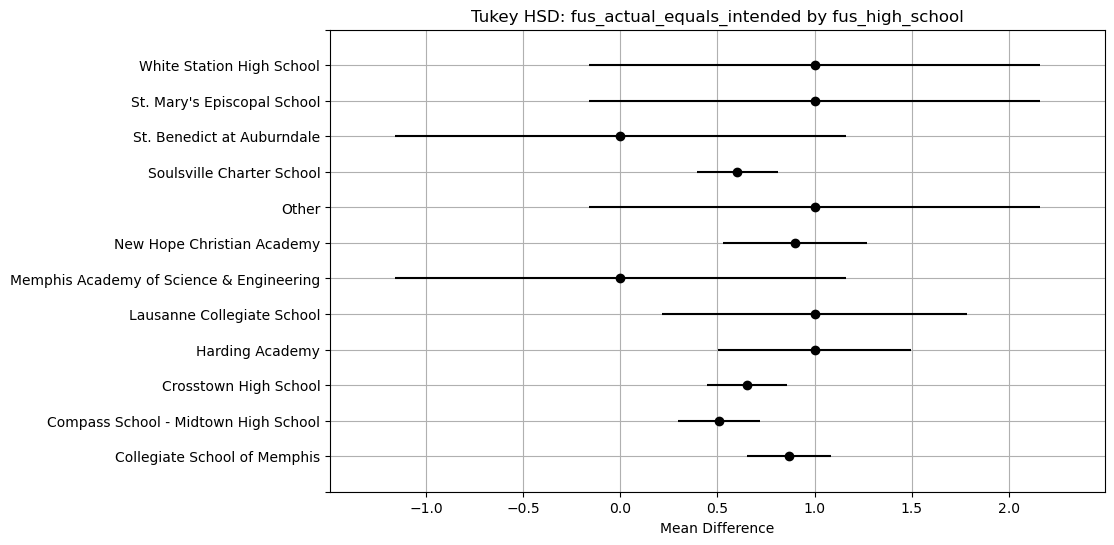

In [12]:
run_glm_nested_comparison(df_combined, outcome='fus_actual_equals_intended', categorical_var='fus_high_school')

### Intention after high school

Nested Model Comparison:
F-statistic = 88.4443, p-value = 0.00000000

Group Means Table:
  fus_intention_after_high_school_originally_reported  \
0                           2-year community college    
1                          4-year college/university    
2                             technical/trade school    
3                                 Enter the military    
4                     Go directly into the workforce    
5                                       I don't know    
6                                    Take a gap year    
7                                          Workforce    

   fus_actual_equals_intended  
0                    0.611111  
1                    0.908088  
2                    0.126437  
3                    0.000000  
4                    0.000000  
5                    0.000000  
6                    0.000000  
7                    0.000000  

Tukey HSD Results:
                        Multiple Comparison of Means - Tukey HSD, FWER=0.05              

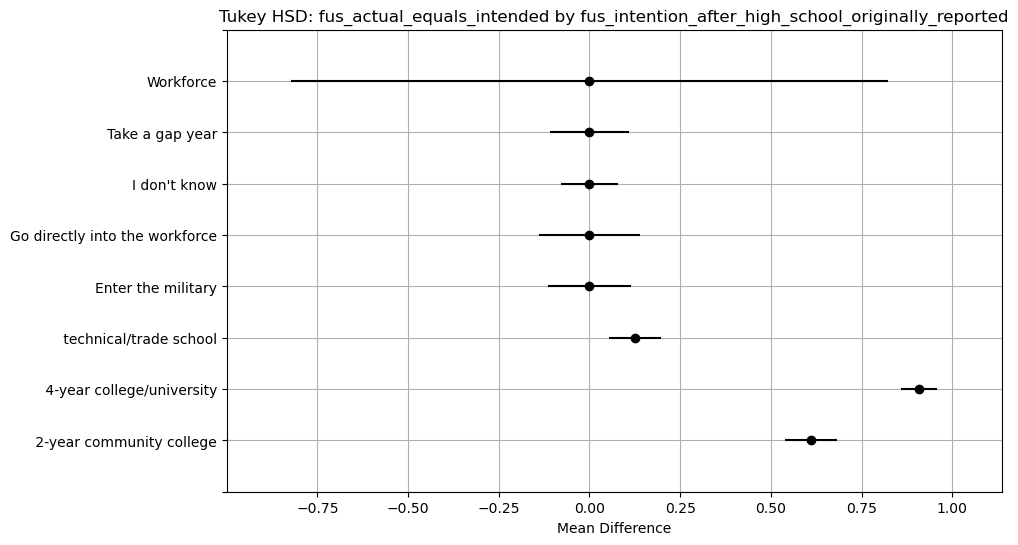

In [13]:
run_glm_nested_comparison(df_combined, outcome='fus_actual_equals_intended', categorical_var='fus_intention_after_high_school_originally_reported')

### Gender

Nested Model Comparison:
F-statistic = 6.5266, p-value = 0.00003579

Group Means Table:
             fus_gender  fus_actual_equals_intended
0  Choose Not to Answer                    0.500000
1                Female                    0.719818
2                  Male                    0.565097
3             Nonbinary                    0.666667
4                 Other                    1.000000

Tukey HSD Results:
         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
       group1          group2  meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------
Choose Not to Answer    Female   0.2198 0.5895 -0.1921  0.6317  False
Choose Not to Answer      Male   0.0651 0.9928 -0.3478   0.478  False
Choose Not to Answer Nonbinary   0.1667  0.898 -0.3413  0.6746  False
Choose Not to Answer     Other      0.5 0.2981 -0.2054  1.2054  False
              Female      Male  -0.1547    0.0 -0.2462 -0.0632   True
              Female

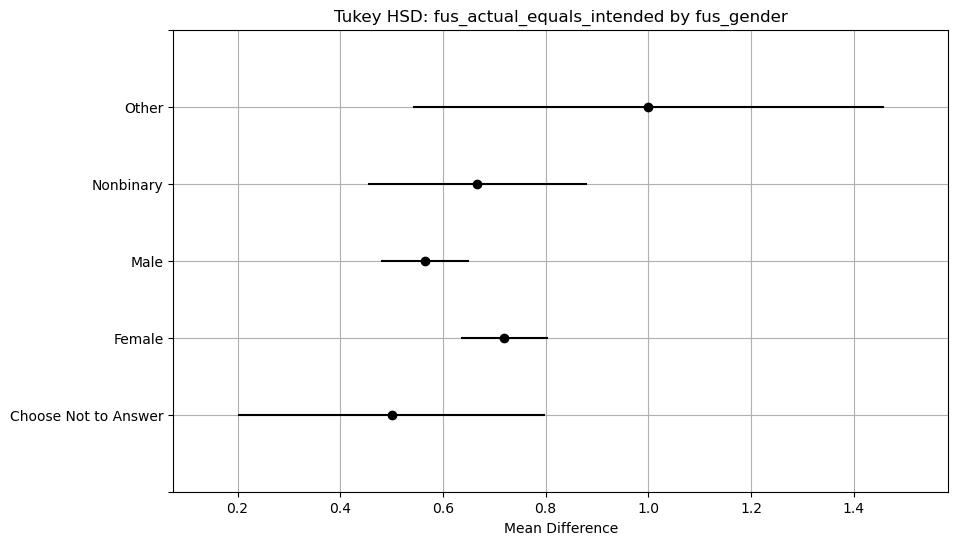

In [14]:
run_glm_nested_comparison(df_combined, outcome='fus_actual_equals_intended', categorical_var='fus_gender')

### High school graduation year

Nested Model Comparison:
F-statistic = 2.8746, p-value = 0.05697420

Group Means Table:
   ss_student_high_school_graduation_year  fus_actual_equals_intended
0                                    2023                    0.642599
1                                    2024                    0.686667
2                                    2025                    0.592593

Tukey HSD Results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  2023   2024   0.0441 0.5118 -0.0496 0.1378  False
  2023   2025    -0.05 0.4242 -0.1439 0.0439  False
  2024   2025  -0.0941 0.0439 -0.1861 -0.002   True
---------------------------------------------------


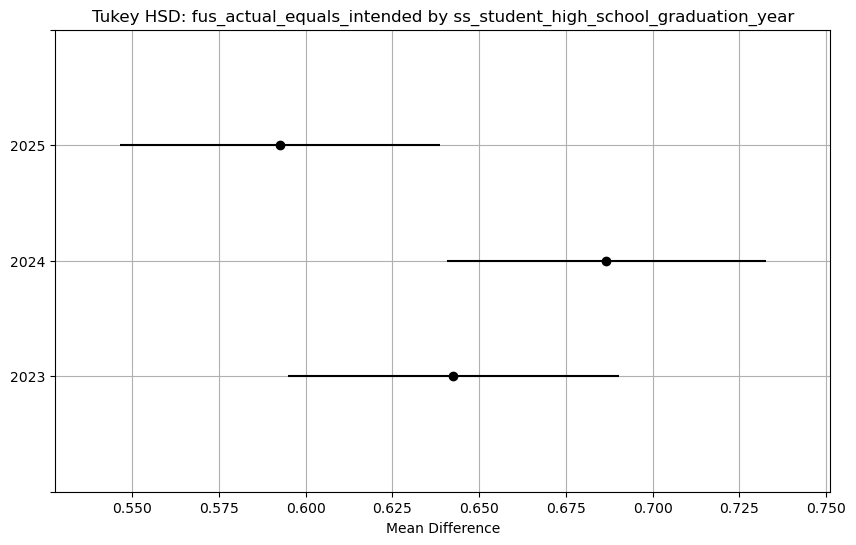

In [15]:
run_glm_nested_comparison(df_combined, outcome='fus_actual_equals_intended', categorical_var='ss_student_high_school_graduation_year')

# fus_actual_equals_intended_or_better

## Analyses: Logistic Regression

- ACT: `ss_act_score`
- GPA: `ss_unweighted_gpa`

### GPA

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Generalized Linear Model Regression Results                           
================================================================================================
Dep. Variable:     fus_actual_equals_intended_or_better   No. Observations:                  330
Model:                                              GLM   Df Residuals:                      328
Model Family:                                  Binomial   Df Model:                            1
Link Function:                                    Logit   Scale:                          1.0000
Method:                                            IRLS   Log-Likelihood:                -130.91
Date:                                  Wed, 02 Jul 2025   Deviance:                       261.83
Time:                                          17:02:10   Pearson chi2:                     321.
No. Iterations:                                       5   Pseudo R-squ. (CS):            0.05563
Covariance Type:                              nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -2.2612      0.903     -2.503      0.012      -4.032      -0.491
ss_unweighted_gpa     1.2044      0.278      4.335      0.000       0.660       1.749
=====================================================================================
"""

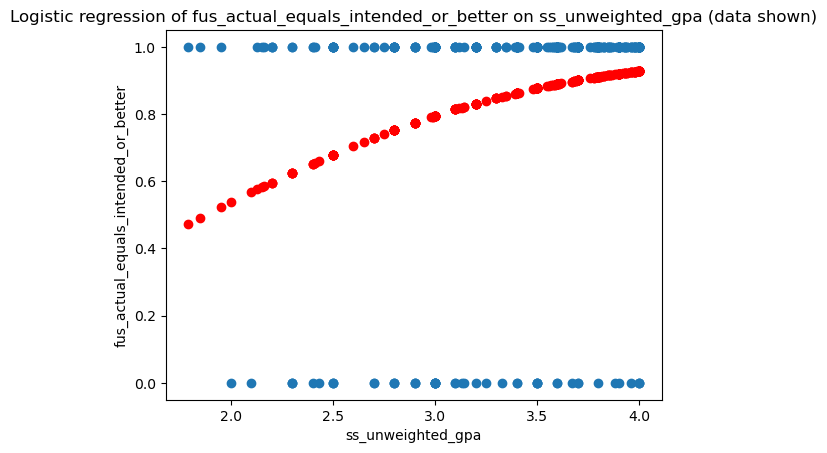

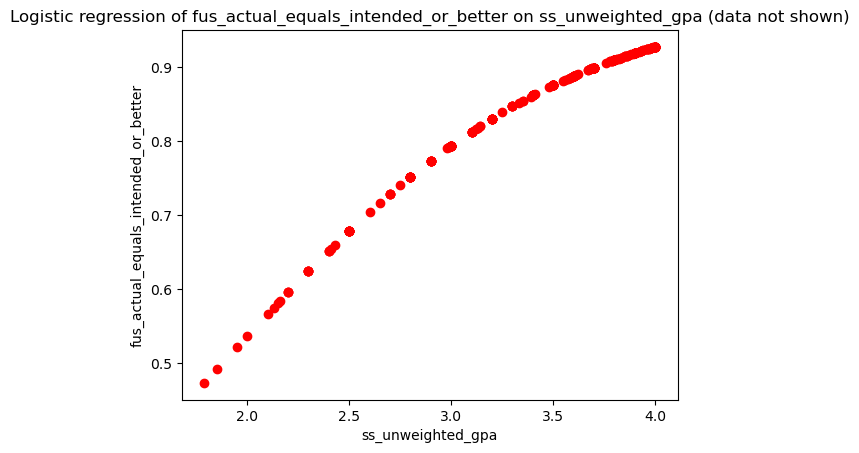

In [16]:
temp = df_combined

temp = temp[temp['ss_unweighted_gpa'] <= 4]

run_logistic_regression(temp, outcome='fus_actual_equals_intended_or_better', predictor='ss_unweighted_gpa')

### ACT

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Generalized Linear Model Regression Results                           
================================================================================================
Dep. Variable:     fus_actual_equals_intended_or_better   No. Observations:                  613
Model:                                              GLM   Df Residuals:                      611
Model Family:                                  Binomial   Df Model:                            1
Link Function:                                    Logit   Scale:                          1.0000
Method:                                            IRLS   Log-Likelihood:                -256.11
Date:                                  Wed, 02 Jul 2025   Deviance:                       512.22
Time:                                          17:02:43   Pearson chi2:                     608.
No. Iterations:                                       5   Pseudo R-squ. (CS):            0.04238
Covariance Type:                              nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.9764      0.542     -1.802      0.072      -2.038       0.086
ss_act_score     0.1364      0.029      4.758      0.000       0.080       0.193
================================================================================
"""

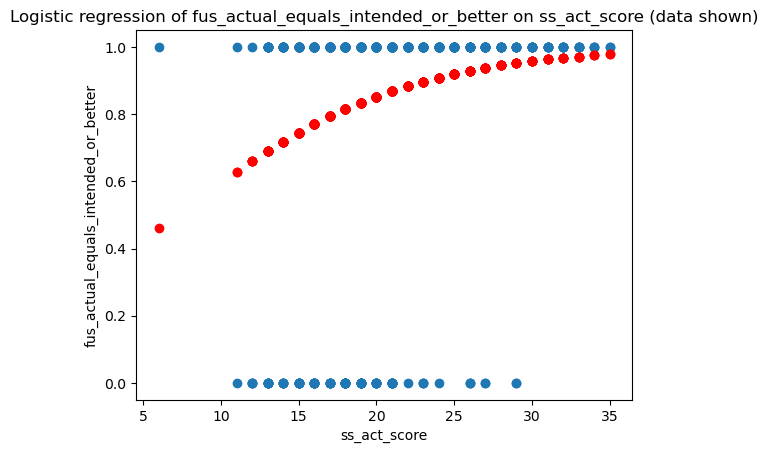

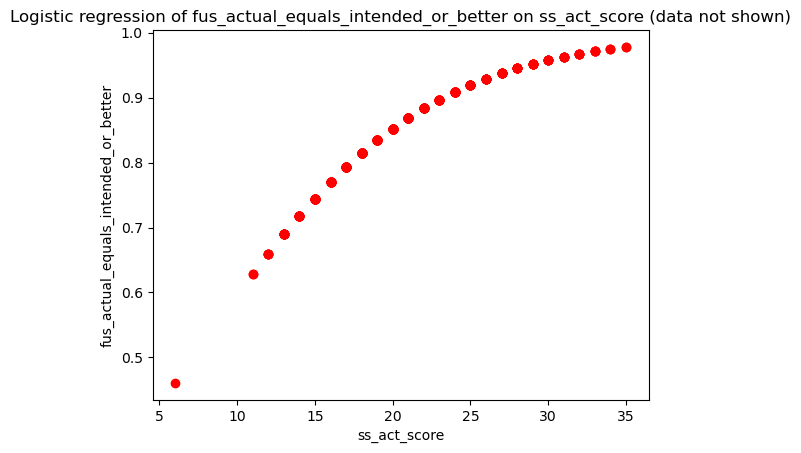

In [17]:
temp = df_combined

# Filter crazy values before fitting the model, ACT is 1 to 36 but I doubt the "2" scores are real
temp = temp[temp['ss_act_score'] > 2]
temp = temp[temp['ss_act_score'] <= 36]

run_logistic_regression(temp, outcome='fus_actual_equals_intended_or_better', predictor='ss_act_score')

## Analyses: Logistic ANOVA

- Race/ethnicity: `fus_race_ethnicity`
- High school: `fus_high_school`
- Gender: `fus_gender`
- **Intention after high school** is a new one you added, looks cool
- Graduation year: `ss_student_high_school_graduation_year`

### Race

Nested Model Comparison:
F-statistic = 1.1907, p-value = 0.30534221

Group Means Table:
                 fus_race_ethnicity  fus_actual_equals_intended_or_better
0                             Asian                              0.888889
1            Black/African American                              0.759300
2              Choose Not to Answer                              0.608696
3  Hispanic or Latino/Latina/LatinX                              0.757143
4      Middle Eastern/North African                              1.000000
5                      Multi-Racial                              0.781250
6                             Other                              0.833333
7                             White                              0.831683

Tukey HSD Results:
                          Multiple Comparison of Means - Tukey HSD, FWER=0.05                          
             group1                           group2              meandiff p-adj   lower  upper  reject
------------------

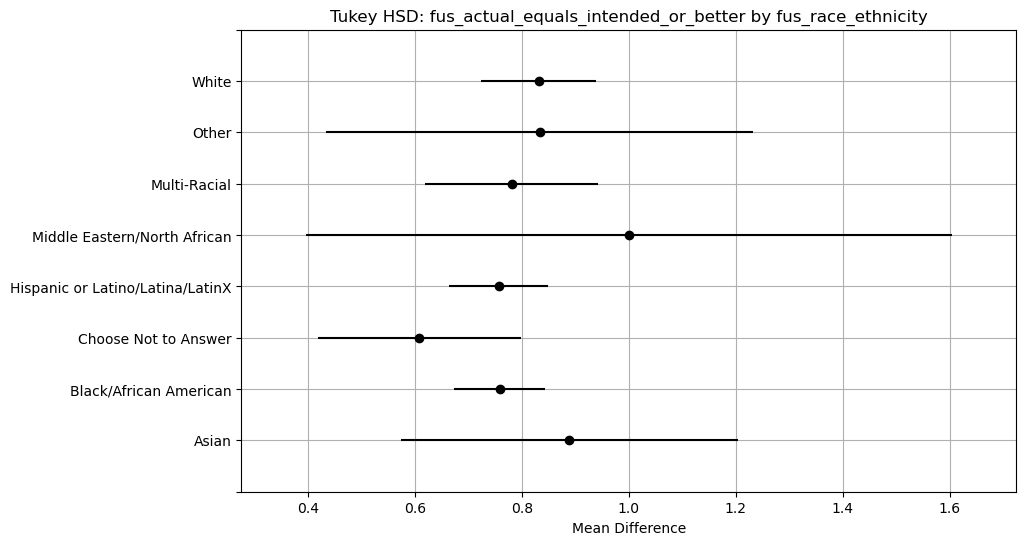

In [18]:
run_glm_nested_comparison(df_combined, outcome='fus_actual_equals_intended_or_better', categorical_var='fus_race_ethnicity')

### High school graduation year

Nested Model Comparison:
F-statistic = 1.6300, p-value = 0.19652993

Group Means Table:
   ss_student_high_school_graduation_year  \
0                                    2023   
1                                    2024   
2                                    2025   

   fus_actual_equals_intended_or_better  
0                              0.758123  
1                              0.803333  
2                              0.744108  

Tukey HSD Results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  2023   2024   0.0452 0.4027 -0.0372 0.1277  False
  2023   2025   -0.014 0.9164 -0.0967 0.0686  False
  2024   2025  -0.0592 0.1995 -0.1402 0.0218  False
---------------------------------------------------


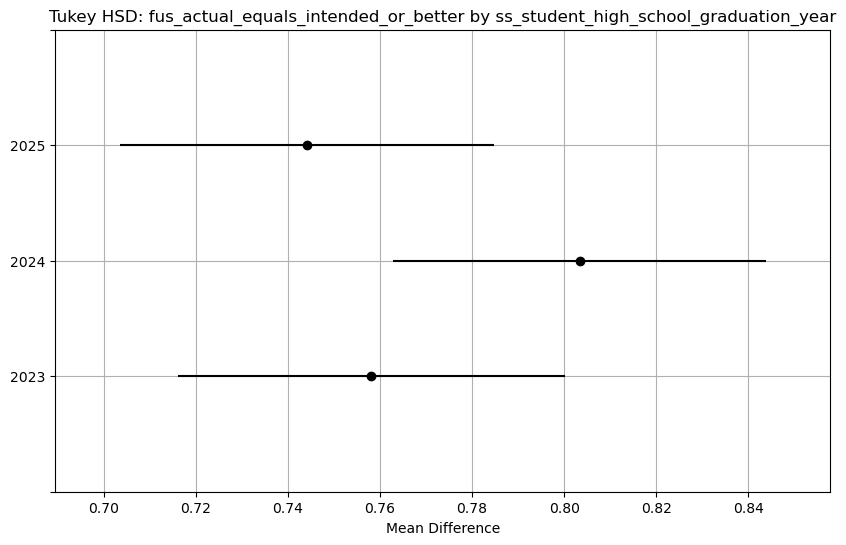

In [19]:
run_glm_nested_comparison(df_combined, outcome='fus_actual_equals_intended_or_better', categorical_var='ss_student_high_school_graduation_year')

### High school

Nested Model Comparison:
F-statistic = 5.1957, p-value = 0.00000006

Group Means Table:
                             fus_high_school  \
0               Collegiate School of Memphis   
1       Compass School - Midtown High School   
2                      Crosstown High School   
3                            Harding Academy   
4                 Lausanne Collegiate School   
5   Memphis Academy of Science & Engineering   
6                 New Hope Christian Academy   
7                                      Other   
8                  Soulsville Charter School   
9                 St. Benedict at Auburndale   
10               St. Mary's Episcopal School   
11                 White Station High School   

    fus_actual_equals_intended_or_better  
0                               0.966942  
1                               0.675393  
2                               0.760383  
3                               1.000000  
4                               1.000000  
5                            

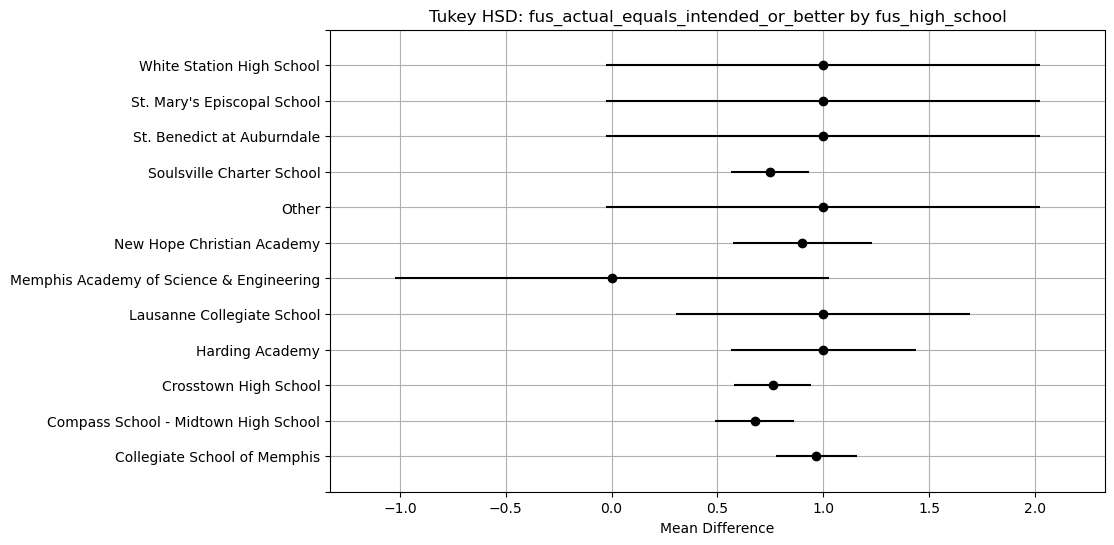

In [20]:
run_glm_nested_comparison(df_combined, outcome='fus_actual_equals_intended_or_better', categorical_var='fus_high_school')

### Intention after high school

Nested Model Comparison:
F-statistic = 32.8311, p-value = 0.00000000

Group Means Table:
  fus_intention_after_high_school_originally_reported  \
0                           2-year community college    
1                          4-year college/university    
2                             technical/trade school    
3                                 Enter the military    
4                     Go directly into the workforce    
5                                       I don't know    
6                                    Take a gap year    
7                                          Workforce    

   fus_actual_equals_intended_or_better  
0                              0.788889  
1                              0.908088  
2                              0.609195  
3                              0.225806  
4                              0.000000  
5                              0.439394  
6                              0.545455  
7                              0.000000  

Tukey HSD Results:

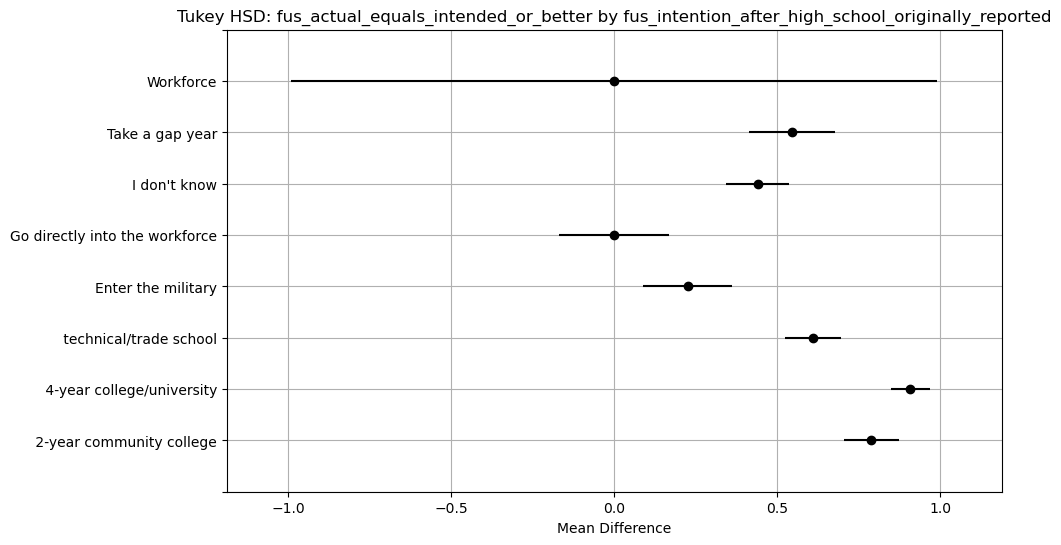

In [21]:
run_glm_nested_comparison(df_combined, outcome='fus_actual_equals_intended_or_better', categorical_var='fus_intention_after_high_school_originally_reported')

### Gender

Nested Model Comparison:
F-statistic = 2.5911, p-value = 0.03547759

Group Means Table:
             fus_gender  fus_actual_equals_intended_or_better
0  Choose Not to Answer                              0.600000
1                Female                              0.813212
2                  Male                              0.747922
3             Nonbinary                              0.666667
4                 Other                              1.000000

Tukey HSD Results:
        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
       group1          group2  meandiff p-adj   lower  upper  reject
--------------------------------------------------------------------
Choose Not to Answer    Female   0.2132 0.4883 -0.1478 0.5742  False
Choose Not to Answer      Male   0.1479 0.7973 -0.2139 0.5098  False
Choose Not to Answer Nonbinary   0.0667 0.9941 -0.3785 0.5118  False
Choose Not to Answer     Other      0.4 0.3926 -0.2182 1.0182  False
              Female      Male  -0.06

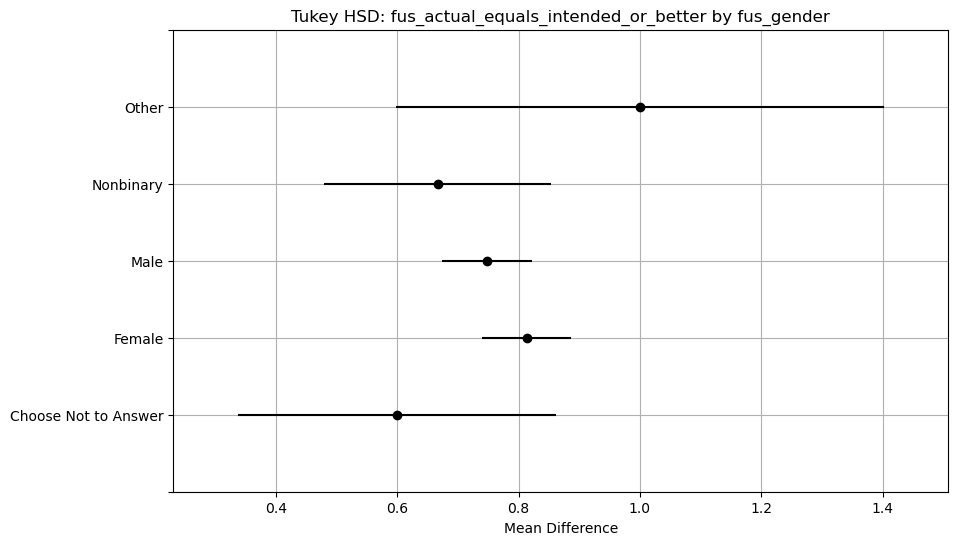

In [22]:
run_glm_nested_comparison(df_combined, outcome='fus_actual_equals_intended_or_better', categorical_var='fus_gender')